In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Install required libraries
!pip install -q transformers datasets

# Import libraries
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



In [ ]:
# Load and preprocess dataset
df = pd.read_csv('/content/drive/MyDrive/COVID-19_Sentiments.csv')
df = df[['Text', 'Sentiments']].dropna()

# Convert to sentiment labels: 0=Negative, 1=Neutral, 2=Positive
def convert_label(value):
    if value < 0:
        return "negative"
    elif value == 0:
        return "neutral"
    else:
        return "positive"

df['label'] = df['Sentiments'].apply(convert_label)

# Reduce size for memory
df = df.sample(n=3000, random_state=42).reset_index(drop=True)

# Prepare input and target for T5
df['input_text'] = "classify sentiment: " + df['Text']
df['target_text'] = df['label']

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['input_text'], df['target_text'], test_size=0.2, random_state=42
)

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Tokenize
def tokenize_data(texts, labels, tokenizer, max_length=128):
    inputs = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt", max_length=max_length)
    targets = tokenizer(list(labels), padding=True, truncation=True, return_tensors="pt", max_length=16)
    return inputs.input_ids, inputs.attention_mask, targets.input_ids

train_input_ids, train_attention_mask, train_labels_ids = tokenize_data(train_texts, train_labels, tokenizer)
test_input_ids, test_attention_mask, test_labels_ids = tokenize_data(test_texts, test_labels, tokenizer)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
model.train()

epochs = 3  # reduce if memory is tight
batch_size = 8

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(train_input_ids), batch_size):
        input_ids = train_input_ids[i:i+batch_size].to(device)
        attention_mask = train_attention_mask[i:i+batch_size].to(device)
        labels = train_labels_ids[i:i+batch_size].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 64 == 0:
            print(f"Step {i}/{len(train_input_ids)} - Loss: {loss.item():.4f}")

# Evaluation
model.eval()
preds = []

with torch.no_grad():
    for i in range(0, len(test_input_ids), batch_size):
        input_ids = test_input_ids[i:i+batch_size].to(device)
        attention_mask = test_attention_mask[i:i+batch_size].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=16)
        decoded_preds = [tokenizer.decode(out, skip_special_tokens=True) for out in outputs]
        preds.extend(decoded_preds)

print("\nClassification Report:")
print(classification_report(test_labels, preds, target_names=["negative", "neutral", "positive"]))


Epoch 1/3
Step 0/2400 - Loss: 8.5540
Step 64/2400 - Loss: 1.1117
Step 128/2400 - Loss: 0.5676
Step 192/2400 - Loss: 0.8091
Step 256/2400 - Loss: 0.8092
Step 320/2400 - Loss: 0.8827
Step 384/2400 - Loss: 0.4189
Step 448/2400 - Loss: 0.4736
Step 512/2400 - Loss: 0.4824
Step 576/2400 - Loss: 0.5050
Step 640/2400 - Loss: 0.4431
Step 704/2400 - Loss: 0.3893
Step 768/2400 - Loss: 0.6399
Step 832/2400 - Loss: 0.5539
Step 896/2400 - Loss: 0.6709
Step 960/2400 - Loss: 0.3921
Step 1024/2400 - Loss: 0.3670
Step 1088/2400 - Loss: 0.6857
Step 1152/2400 - Loss: 0.5417
Step 1216/2400 - Loss: 0.5811
Step 1280/2400 - Loss: 0.5422
Step 1344/2400 - Loss: 0.5519
Step 1408/2400 - Loss: 0.5502
Step 1472/2400 - Loss: 0.4322
Step 1536/2400 - Loss: 0.6564
Step 1600/2400 - Loss: 0.5794
Step 1664/2400 - Loss: 0.4371
Step 1728/2400 - Loss: 0.3932
Step 1792/2400 - Loss: 0.5552
Step 1856/2400 - Loss: 0.5689
Step 1920/2400 - Loss: 0.4453
Step 1984/2400 - Loss: 0.3081
Step 2048/2400 - Loss: 0.2597
Step 2112/2400 - Lo

In [ ]:
# Print confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(test_labels, preds, labels=["negative", "neutral", "positive"]))


Confusion Matrix:
 [[ 74  22  24]
 [ 10 217  15]
 [ 14  11 213]]


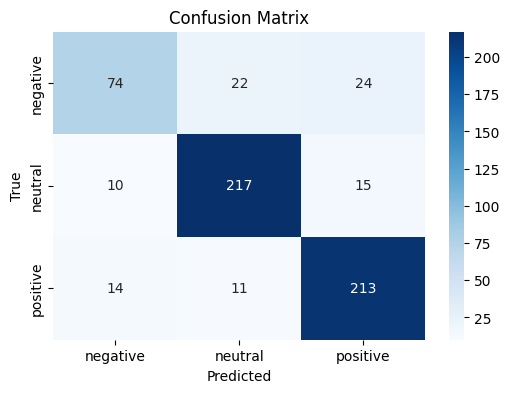

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, preds, labels=["negative", "neutral", "positive"])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
